<a href="https://colab.research.google.com/github/akhil1198/RL-PA1/blob/main/RL_PA_1_Q_Learning_SARSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install gymnasium matplotlib numpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 5.7 MB/s eta 0:00:00


In [4]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

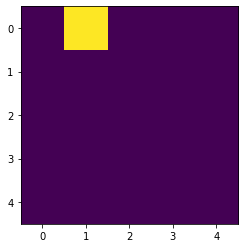

<IPython.core.display.Javascript object>

In [5]:
output_grid = widgets.Grid(1,1)

for _ in range(5):
  grid = np.zeros((5, 5))
  grid[np.random.randint(5), np.random.randint(5)] = 1

  with output_grid.output_to(0,0):
    output_grid.clear_cell()
    plt.imshow(grid)
  time.sleep(2) 

Creating an Environment with all the actions, states, rewards and positions

In [209]:
from IPython.utils.path import random
class GridEnv(gym.Env):
  def __init__(self, env_type):
    self.environment_type = env_type
    self.environment_width = 5
    self.environment_height = 5
    self.observation_space = spaces.Discrete(25)
    self.action_space = spaces.Discrete(4)

    self.timestep = 0
    self.max_timesteps = 15

    self.agent_pos = [0, 0]
    self.goal_pos = [4, 4]

    self.state = np.zeros((5,5))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5

    self.reward = 0
    self.truncated = False
    self.terminated = False
    self.reward_pos = np.asarray([[0, 4], [2, 1], [3, 4], [4, 2]])
    self.negreward_pos = np.asarray([[1, 2], [3, 0], [3, 3]])

    #for stochastic env
    self.random_number = 0
    self.rand_action = 0

  def reset(self):
    self.state = np.zeros((5,5))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()

    return observation, self.agent_pos
  
  def step(self, action):
    # print("action", action)
    # action = int(action)
    if action == 0:
      #print("at 0 - > agent_pos[0] += 1")
      self.agent_pos[0] += 1
    if action == 1:
      #print("at 1 -> agent_pos[0] -= 1")
      self.agent_pos[0] -= 1
    if action == 2:
      #print("at 2 -> agent_pos[1] += 1")
      self.agent_pos[1] += 1
    if action == 3:
      #print("at 3 -> agent_pos[1] -= 1")
      self.agent_pos[1] -= 1
    #stochastic method
    if self.environment_type == "stochastic":
      self.random_number = np.random.rand()
      self.rand_action = np.random.randint(4)
      if self.random_number < 0.9:
        #print("Executing the right action -> ", action)
        if action == 0:
          #print("at 0 - > agent_pos[0] += 1")
          self.agent_pos[0] += 1
        if action == 1:
          #print("at 1 -> agent_pos[0] -= 1")
          self.agent_pos[0] -= 1
        if action == 2:
          #print("at 2 -> agent_pos[1] += 1")
          self.agent_pos[1] += 1
        if action == 3:
          #print("at 3 -> agent_pos[1] -= 1")
          self.agent_pos[1] -= 1
      elif self.random_number > 0.9:
        #print("Executing Random Action", self.rand_action)
        if self.rand_action == 0:
          self.agent_pos[0] += 1
        if self.rand_action == 1:
          self.agent_pos[0] -= 1
        if self.rand_action == 2:
          self.agent_pos[1] += 1
        if self.rand_action == 3:
          self.agent_pos[1] -= 1
      
    #print(self.agent_pos)
    #Comment this to demonstrate the truncation condition.
    self.agent_pos = np.clip(self.agent_pos, 0, 4)

    self.state = np.zeros((5,5))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()

    self.reward = 0
    #[0, 4], [2, 1], [3, 4], [4, 2]
    if np.array_equal(self.agent_pos, self.reward_pos[0]):
      self.reward = self.reward + 2
    
    if np.array_equal(self.agent_pos, self.reward_pos[1]):
      self.reward = self.reward + 4
    
    if np.array_equal(self.agent_pos, self.reward_pos[2]):
      self.reward = self.reward + 8
    
    if np.array_equal(self.agent_pos, self.reward_pos[3]):
      self.reward = self.reward + 6
    

    if np.array_equal(self.agent_pos, self.goal_pos):
      self.reward += 10
    

    #[1, 2], [3, 0], [3, 3]
    if np.array_equal(self.agent_pos, self.negreward_pos[0]):
      self.reward = self.reward - 5
    
    if np.array_equal(self.agent_pos, self.negreward_pos[1]):
      self.reward = self.reward - 6
    
    if np.array_equal(self.agent_pos, self.negreward_pos[2]):
      self.reward = self.reward - 2

    self.timestep += 1

    #print("truncated -> ", self.agent_pos,)
    terminated = True if self.timestep >= self.max_timesteps else False
    truncated = True if np.all((self.agent_pos[0] >= 0) & (self.agent_pos[0] <= 4) & (self.agent_pos[1] >= 0) & (self.agent_pos[1] <= 4)) else False

    info = {}
    
    return observation, self.reward, terminated, truncated, info, self.agent_pos

  def render(self):
    print("Reward -> ", self.reward)
    plt.imshow(self.state)
    


Creating a Random Agent 

In [210]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
  def step(self, obs):
    return np.random.choice(self.action_space.n)
  

Starting the execution by calling all the methods in the Environment until termination of process

Deterministic Environment: 

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward ->  0


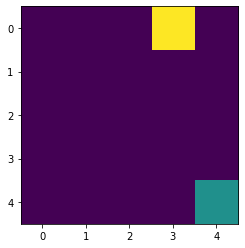

<IPython.core.display.Javascript object>

In [211]:
env = GridEnv(env_type = "deterministic")
agent = RandomAgent(env)

obs, info = env.reset()
terminated, truncated = False, False

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

while not terminated:
  action = agent.step(obs)
  #action = input()
  observation, reward, terminated, truncated, info, agent_pos = env.step(action)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.imshow(grid)
    env.render()
  time.sleep(1)


************************************************************************
Stochastic Environment: 

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward ->  0


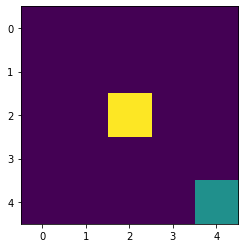

<IPython.core.display.Javascript object>

In [212]:
env = GridEnv(env_type = "stochastic")
agent = RandomAgent(env)

obs, info = env.reset()
terminated, truncated = False, False

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

while not terminated:
  action = agent.step(obs)
  #action = input()
  observation, reward, terminated, truncated, info, agent_pos = env.step(action)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.imshow(grid)
    env.render()
  time.sleep(1)

-----------------------------------------------------------------------------
**Part - 2**

---


**Q-Learning for Deterministic Environment**

In [224]:
import random
from IPython.display import clear_output

env = GridEnv(env_type = "deterministic")
agent = RandomAgent(env)

# Hyperparameters
alpha = 0.15
gamma = 0.93
epsilon = 1.0
epsilon_val = []
reward_val = []

num_episodes = 500

# For plotting metrics
all_epochs = []
all_penalties_q_det = []
avg_reward_per_ep_q_det = []
#Q-Table
q_table = np.random.rand(25, 4)
q_table = q_table.astype(int)

#running for 500 episodes
for episode in range(num_episodes):
  #resetting the state 
  state, agent_pos = env.reset()
  epochs = 0
  penalties = 0
  new_penalties = 0
  new_reward = 0
  avg_reward = 0
  index = 0
  state_to_list = state.tolist()
  if 1 in state_to_list:
    index = state_to_list.index(1)
  # print(index)
  for timestep in range(15):
    #Choosing an action based on e-greedy policy
    if np.random.rand() < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      action = np.argmax(q_table[index])

    # action = np.clip(action, 0, 3)
    observation, reward, terminated, truncated, info, new_agent_pos = env.step(action)

    new_state_to_list = observation.tolist()
    if 1 in new_state_to_list:
      index2 = new_state_to_list.index(1)

    q_table[index, action] = q_table[index, action] + alpha * (reward + gamma * np.argmax(q_table[index2]) - q_table[index, action])

    if reward == -5 or reward == -6 or reward == -2:
      penalties += 1

    new_penalties += penalties
    new_reward += reward
    agent_pos = new_agent_pos
    epochs += 1
  avg_reward = new_reward / 15
  avg_reward_per_ep_q_det.append(avg_reward)
  all_penalties_q_det.append(new_penalties)
  reward_val.append(new_reward)
  epsilon *= 0.9908
  epsilon_val.append(epsilon)

# print("Q-Table : ", q_table)
# print(epsilon_val)


**Epsilon-Decay Graph**

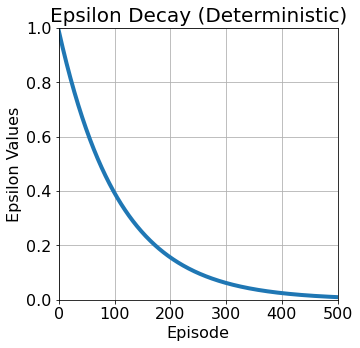

In [214]:
plt.figure(figsize=(5,5))
plt.plot(epsilon_val, linewidth=4)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Epsilon Values', fontsize=16)
plt.title('Epsilon Decay (Deterministic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=500)
plt.grid()
plt.show()

**Total Rewards per episode**

150


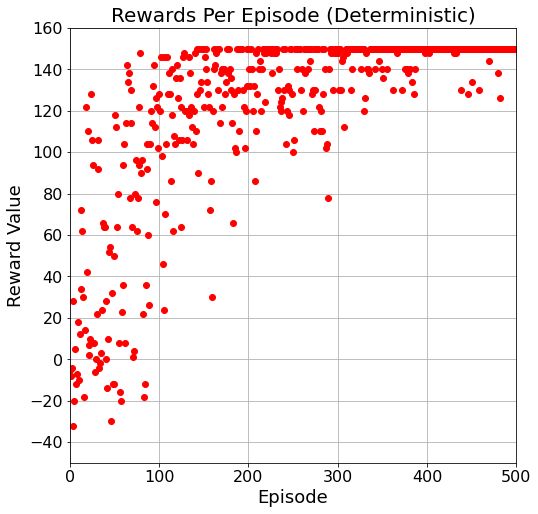

In [233]:
print(max(reward_val))
plt.figure(figsize=(8,8))
plt.plot(reward_val, 'ro')
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Reward Value', fontsize=18)
plt.title('Rewards Per Episode (Deterministic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160], fontsize=16)
plt.ylim(ymin=-50, ymax=160)
plt.xlim(xmin=0, xmax=500)
plt.grid()
plt.show()

In [241]:
# plt.figure(figsize=(8,8))
# plt.plot(avg_reward_per_ep_q_det, 'bo')
# plt.xlabel('Episode', fontsize=18)
# plt.ylabel('Penalties', fontsize=18)
# plt.title('Average Rewards Per Episode (Q-Learning - Deterministic)', fontsize=20)
# plt.xticks(fontsize=16)
# plt.yticks([-6, -4, -2, 0, 2, 4, 6, 8, 10], fontsize=16)
# plt.ylim(ymin=-7, ymax=11)
# plt.xlim(xmin=0, xmax=500)
# plt.grid()
# plt.show()

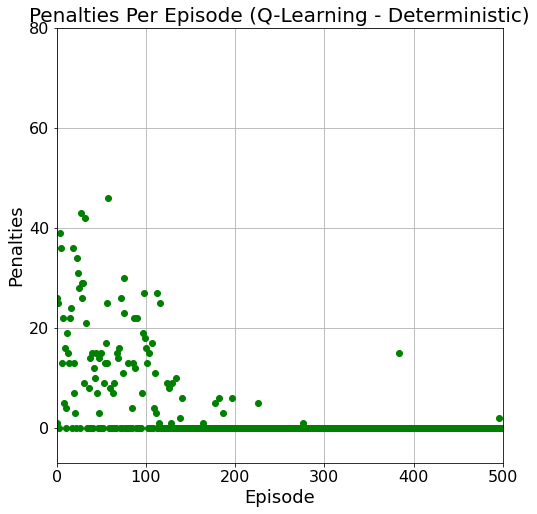

In [216]:
plt.figure(figsize=(8,8))
plt.plot(all_penalties_q_det, 'go')
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Penalties', fontsize=18)
plt.title('Penalties Per Episode (Q-Learning - Deterministic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-60, -50, -20, 0, 20, 40, 60, 80, 100], fontsize=16)
plt.ylim(ymin=-7, ymax=80)
plt.xlim(xmin=0, xmax=500)
plt.grid()
plt.show()

**Q-Learning for Stochastic Environment**

In [234]:
import random
from IPython.display import clear_output

env = GridEnv(env_type = "stochastic")
agent = RandomAgent(env)

# Hyperparameters
alpha = 0.15
gamma = 0.93
epsilon = 1.0
epsilon_val_stoc = []
reward_val_stoc = []

num_episodes = 500

# For plotting metrics
all_epochs = []
all_penalties_q_stoc = []
avg_reward_per_ep_q_stoc = []
#Q-Table
q_table_stoc = np.random.rand(25, 4)
q_table_stoc = q_table_stoc.astype(int)

#running for 1000 episodes
for episode in range(num_episodes):
  #resetting the state 
  state, agent_pos = env.reset()
  epochs = 0
  penalties = 0
  new_penalties = 0
  new_reward = 0
  index 
  state_to_list = state.tolist()
  if 1 in state_to_list:
    index = state_to_list.index(1)
  # print(index)
  
  for timestep in range(15):
    #Choosing an action based on e-greedy policy
    if np.random.rand() < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      action = np.argmax(q_table_stoc[index])

    penalties = 0
    # action = np.clip(action, 0, 3)
    observation, reward, terminated, truncated, info, new_agent_pos = env.step(action)

    new_state_to_list = observation.tolist()
    if 1 in new_state_to_list:
      index2 = new_state_to_list.index(1)

    q_table_stoc[index, action] = q_table_stoc[index, action] + alpha * (reward + gamma * np.max(q_table_stoc[index2]) - q_table_stoc[index, action])

    if reward == -5 or reward == -6 or reward == -2:
      penalties += 1

    new_reward += reward
    index = index2
    epochs += 1
    new_penalties += penalties
  
  avg_reward = new_reward / 15
  avg_reward_per_ep_q_stoc.append(avg_reward)
  all_penalties_q_stoc.append(new_penalties)
  reward_val_stoc.append(new_reward)
  epsilon *= 0.9908
  epsilon_val_stoc.append(epsilon)
  # print(epsilon)

# print("Q-Table : ", q_table)
# print(epsilon_val)


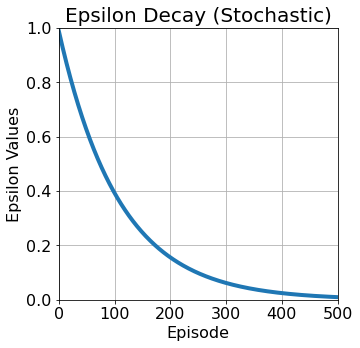

In [235]:
plt.figure(figsize=(5,5))
plt.plot(epsilon_val_stoc, linewidth=4)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Epsilon Values', fontsize=16)
plt.title('Epsilon Decay (Stochastic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=500)
plt.grid()
plt.show()

[-5, -8, -4, 28, -32, -20, 5, -12, -7, 18, -10, 12, 72, 34, 62, 30, -18, 14, 122, 42, 110, 7, 2, 10, 128, 106, 94, 8, -6, 0, 22, 92, 106, -4, -2, 3, 24, 66, 64, 64, 28, 0, -14, 10, 52, 54, -30, 32, -12, -12, 50, 118, 112, 64, 80, 8, -16, -20, 23, 36, 94, 104, 8, 114, 142, 134, 138, 78, 130, 114, 64, 1, 4, 80, 96, 62, 78, 94, 122, 148, 90, 96, 22, -18, -12, 36, 104, 92, 60, 26, 104, 120, 114, 132, 142, 112, 126, 76, 122, 102, 128, 120, 146, 98, 46, 24, 146, 70, 104, 146, 128, 138, 128, 86, 118, 140, 62, 108, 104, 136, 142, 126, 106, 136, 122, 64, 106, 146, 148, 120, 120, 106, 120, 118, 146, 138, 122, 112, 104, 120, 148, 110, 128, 150, 90, 150, 130, 134, 150, 150, 122, 146, 150, 140, 134, 128, 122, 72, 86, 30, 120, 140, 150, 142, 148, 150, 130, 150, 114, 138, 140, 122, 140, 140, 128, 134, 150, 138, 150, 140, 136, 130, 114, 66, 128, 102, 100, 150, 130, 110, 150, 150, 150, 150, 130, 122, 102, 120, 132, 150, 150, 140, 132, 150, 140, 120, 132, 86, 110, 148, 128, 150, 140, 144, 120, 140, 150,

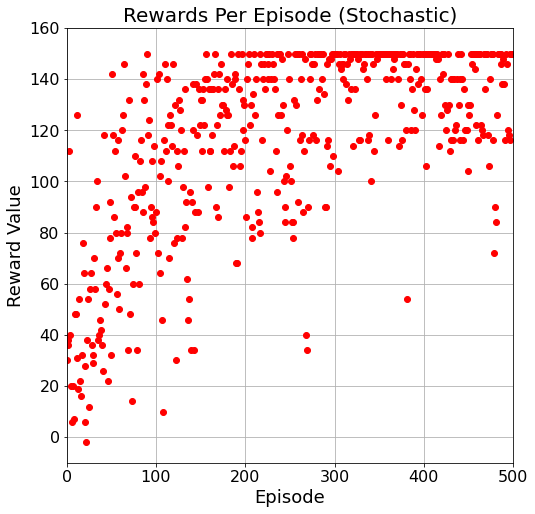

In [236]:
print(reward_val)
plt.figure(figsize=(8,8))
plt.plot(reward_val_stoc, 'ro')
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Reward Value', fontsize=18)
plt.title('Rewards Per Episode (Q-Learning - Stochastic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160], fontsize=16)
plt.ylim(ymin=-10, ymax=160)
plt.xlim(xmin=0, xmax=500)
plt.grid()
plt.show()

In [240]:
# plt.figure(figsize=(8,8))
# plt.plot(avg_reward_per_ep_q_stoc, 'bo')
# plt.xlabel('Episode', fontsize=18)
# plt.ylabel('Penalties', fontsize=18)
# plt.title('Average Rewards Per Episode (Q-Learning - Stochastic)', fontsize=20)
# plt.xticks(fontsize=16)
# plt.yticks([-6, -4, -2, 0, 2, 4, 6, 8, 10], fontsize=16)
# plt.ylim(ymin=-7, ymax=11)
# plt.xlim(xmin=0, xmax=500)
# plt.grid()
# plt.show()

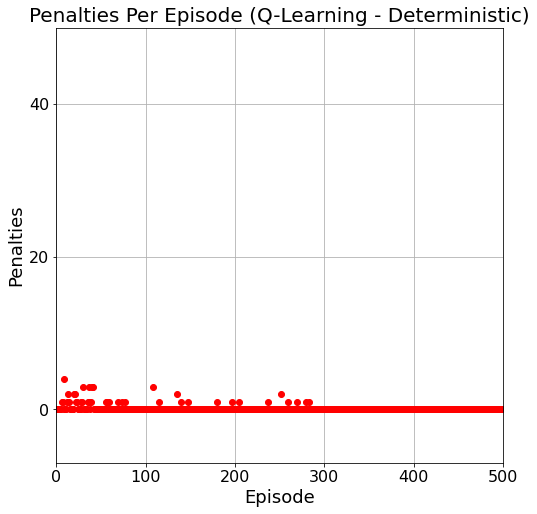

In [237]:
plt.figure(figsize=(8,8))
plt.plot(all_penalties_q_stoc, 'ro')
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Penalties', fontsize=18)
plt.title('Penalties Per Episode (Q-Learning - Stochastic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-60, -50, -20, 0, 20, 40, 60, 80, 100], fontsize=16)
plt.ylim(ymin=-7, ymax=50)
plt.xlim(xmin=0, xmax=500)
plt.grid()
plt.show()

In [238]:
# Write Q-table to pickle file
with open('q_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)

# Download pickle file
from google.colab import files
files.download('q_table.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Testing Q-Values with 5x5 Grid Environment - Deterministic**

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward ->  10


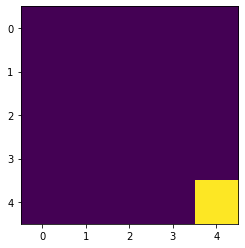

<IPython.core.display.Javascript object>

In [222]:
env = GridEnv(env_type = "deterministic")
agent = RandomAgent(env)

obs, info = env.reset()
terminated, truncated = False, False


output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

def get_max_val(arg):
  return max(arg)
  
for i in q_table:
  max_val = get_max_val(i)
  i_to_list = i.tolist()
  max_index = i_to_list.index(max_val)
  observation, reward, terminated, truncated, info, agent_pos = env.step(max_index)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.imshow(grid)
    env.render()
  time.sleep(1)

  

**Testing Q-Values with 5x5 Grid Environment - Stochastic**

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward ->  10


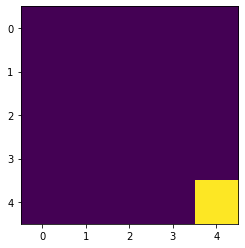

<IPython.core.display.Javascript object>

In [223]:
env = GridEnv(env_type = "stochastic")
agent = RandomAgent(env)

obs, info = env.reset()
terminated, truncated = False, False

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

def get_max_val(arg):
  return max(arg)
  
for i in q_table_stoc:
  max_val = get_max_val(i)
  # print(type(i))
  i_to_list = i.tolist()
  max_index = i_to_list.index(max_val)
  # print(max_index)
  observation, reward, terminated, truncated, info, agent_pos = env.step(max_index)
  # observation, reward, terminated, truncated, info, agent_pos = env.step(action)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.imshow(grid)
    env.render()
  time.sleep(1)

  

In [ ]:
# plot cumulative avg rewards per episdoe 

**SARSA Implementation**

In [243]:
import random
from IPython.display import clear_output

env = GridEnv(env_type = "deterministic")
agent = RandomAgent(env)

# Hyperparameters
alpha = 0.12
gamma = 0.95
epsilon = 1.0
epsilon_sarsa = []
reward_sarsa = []

num_episodes = 1000
max_timesteps = 15

# For plotting metrics
all_epochs = []
all_penalties_sarsa_det = []

state1 = 0
#Q-Table
q_table_sarsa_det = np.random.rand(25, 4)
q_table_sarsa_det = q_table_sarsa_det.astype(int)

#running for 1000 episodes
for episode in range(num_episodes):
  #resetting the state 
  state, agent_pos = env.reset()
  epochs = 0
  penalties = 0

  # print(state)
  state_to_list = state.tolist()
  if 1 in state_to_list:
    state1 = state_to_list.index(1)
  # print(index)
  new_reward = 0
  new_penalties = 0

  for timestep in range(max_timesteps):
    #Choosing an action based on e-greedy policy
    if np.random.rand() < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      action = np.argmax(q_table_sarsa_det[state1])

    #getting the next state, reward
    observation, reward, terminated, truncated, info, new_agent_pos = env.step(action)

    #getting the new state
    new_state_to_list = observation.tolist()
    if 1 in new_state_to_list:
      state2 = new_state_to_list.index(1)

    if np.random.rand() < epsilon:
      action2 = np.random.choice(env.action_space.n)
    else:
      action2 = np.argmax(q_table_sarsa_det[state2])

    q_table_sarsa_det[state1, action] = q_table_sarsa_det[state1, action] + alpha * (reward + gamma * (q_table_sarsa_det[state2, action2] - q_table_sarsa_det[state1, action]))

    if reward == -5 or reward == -6 or reward == -2:
      penalties += 1
    
    # agent_pos = new_agent_pos
    epochs += 1
    new_reward += reward
    state1 = state2
    new_penalties += penalties
  reward_sarsa.append(new_reward)
  all_penalties_sarsa_det.append(new_penalties)
  epsilon *= 0.995
  epsilon_sarsa.append(epsilon)
  # print(epsilon)

# print("Q-Table : ", q_table_sarsa)
# print(epsilon_val)
# print("Q Table : ", q_table_sarsa)

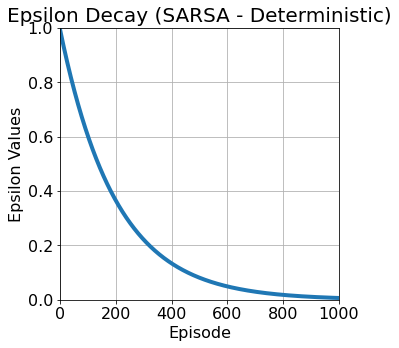

In [244]:
plt.figure(figsize=(5,5))
plt.plot(epsilon_sarsa, linewidth=4)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Epsilon Values', fontsize=16)
plt.title('Epsilon Decay (SARSA - Deterministic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=1000)
plt.grid()
plt.show()

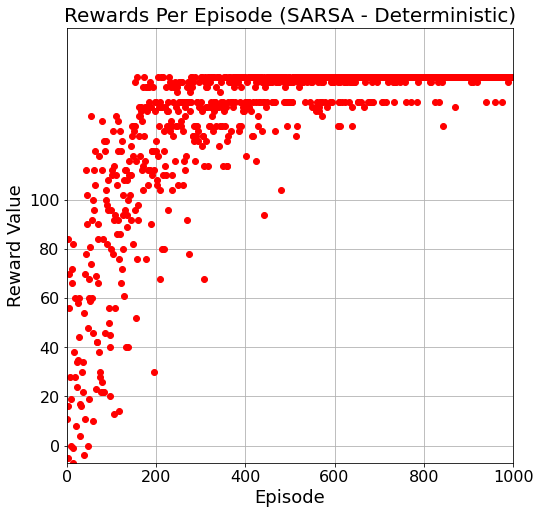

In [245]:
plt.figure(figsize=(8,8))
plt.plot(reward_sarsa, 'ro')
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Reward Value', fontsize=18)
plt.title('Rewards Per Episode (SARSA - Deterministic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-60, -50, -20, 0, 20, 40, 60, 80, 100], fontsize=16)
plt.ylim(ymin=-7, ymax=170)
plt.xlim(xmin=0, xmax=1000)
plt.grid()
plt.show()

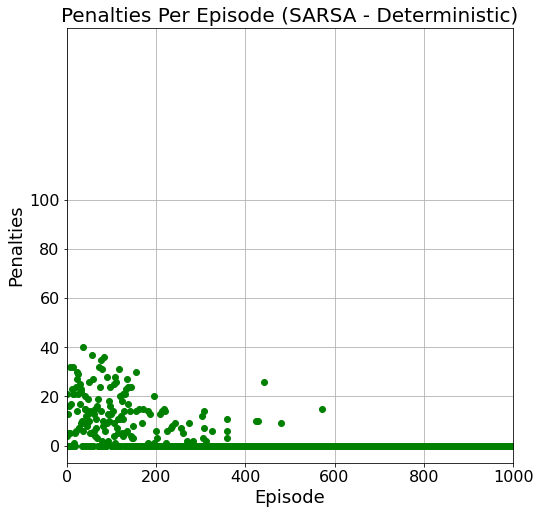

In [246]:
plt.figure(figsize=(8,8))
plt.plot(all_penalties_sarsa_det, 'go')
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Penalties', fontsize=18)
plt.title('Penalties Per Episode (SARSA - Deterministic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-60, -50, -20, 0, 20, 40, 60, 80, 100], fontsize=16)
plt.ylim(ymin=-7, ymax=170)
plt.xlim(xmin=0, xmax=1000)
plt.grid()
plt.show()

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward ->  10


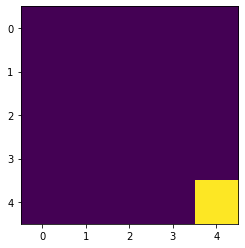

<IPython.core.display.Javascript object>

In [247]:
env = GridEnv(env_type = "deterministic")
agent = RandomAgent(env)

obs, info = env.reset()
terminated, truncated = False, False


output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

def get_max_val(arg):
  return max(arg)
  
for i in q_table_sarsa_det:
  max_val = get_max_val(i)
  i_to_list = i.tolist()
  max_index = i_to_list.index(max_val)
  observation, reward, terminated, truncated, info, agent_pos = env.step(max_index)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.imshow(grid)
    env.render()
  time.sleep(1)

  

In [248]:
import random
from IPython.display import clear_output

env = GridEnv(env_type = "stochastic")
agent = RandomAgent(env)

# Hyperparameters
alpha = 0.12
gamma = 0.95
epsilon = 1.0
epsilon_sarsa_stoc = []
reward_sarsa_stoc = []

num_episodes = 1000
max_timesteps = 15

# For plotting metrics
all_epochs = []
all_penalties = []
state1 = 0
#Q-Table
q_table_sarsa_stoc = np.random.rand(25, 4)
q_table_sarsa_stoc = q_table_sarsa_stoc.astype(int)

#running for 1000 episodes
for episode in range(num_episodes):
  #resetting the state 
  state, agent_pos = env.reset()
  epochs = 0
  # penalties = 0
  new_reward = 0
  # print(state)
  state_to_list = state.tolist()
  if 1 in state_to_list:
    state1 = state_to_list.index(1)
  # print(index)
  
  for timestep in range(max_timesteps):
    #Choosing an action based on e-greedy policy
    if np.random.rand() < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      action = np.argmax(q_table_sarsa_stoc[state1])

    #getting the next state, reward
    observation, reward, terminated, truncated, info, new_agent_pos = env.step(action)

    #getting the new state
    new_state_to_list = observation.tolist()
    if 1 in new_state_to_list:
      state2 = new_state_to_list.index(1)

    if np.random.rand() < epsilon:
      action2 = np.random.choice(env.action_space.n)
    else:
      action2 = np.argmax(q_table_sarsa_stoc[state2])

    q_table_sarsa_stoc[state1, action] = q_table_sarsa_stoc[state1, action] + alpha * (reward + gamma * (q_table_sarsa_stoc[state2, action2] - q_table_sarsa_stoc[state1, action]))

    # if reward == -5 or reward == -6 or reward == -2:
    #   penalties += 1
    
    # agent_pos = new_agent_pos
    epochs += 1
    state1 = state2
    new_reward += reward
  reward_sarsa_stoc.append(new_reward)
  epsilon *= 0.995
  epsilon_sarsa_stoc.append(epsilon)
  # print(epsilon)

# print("Q-Table : ", q_table_sarsa)
# print(epsilon_val)
# print("Q Table : ", q_table_sarsa)

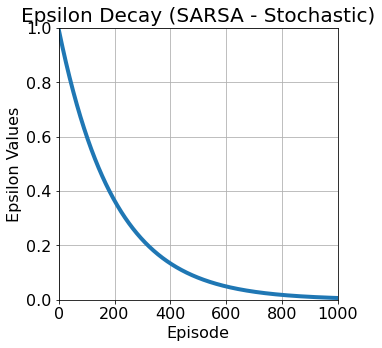

In [249]:
plt.figure(figsize=(5,5))
plt.plot(epsilon_sarsa_stoc, linewidth=4)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Epsilon Values', fontsize=16)
plt.title('Epsilon Decay (SARSA - Stochastic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=1000)
plt.grid()
plt.show()

[10, 10, 42, 3, 2, 56, 28, 36, 56, 84, 8, 30, 30, -6, 26, -18, 12, 30, 48, 13, 70, 36, 30, 7, 8, 100, 48, 20, 22, 30, -8, 118, 96, 128, 104, 28, 18, 0, 7, 104, 60, 18, -6, 28, 2, 40, 34, 82, 64, 94, 132, 71, 130, 80, 70, 102, 48, 134, 74, 28, 104, 40, 34, -6, 66, 112, 106, 86, 40, 58, 94, 48, -12, 26, 26, 112, 69, 58, 20, 3, 128, 84, 22, 28, 74, 70, 84, 6, 42, 70, 52, 82, 74, 70, 86, 118, 36, 122, 82, 128, 116, 78, 68, 2, 84, 70, 94, 68, 126, 88, 100, 70, 32, 106, 94, 58, 52, 104, 114, 112, 82, 120, 66, 26, 108, 120, 64, 76, 32, 82, 124, 66, 100, 90, 106, 90, 74, 108, 90, 88, 106, 68, 94, 32, 74, 64, 116, 92, 140, 26, 114, 94, 96, 108, 90, 98, 72, 116, 128, 138, 126, 130, 134, 110, 114, 98, 102, 42, 100, 90, 150, 96, 134, 110, 126, 130, 106, 72, 120, 150, 118, 47, 94, 138, 128, 102, 126, 118, 96, 140, 132, 106, 128, 92, 136, 104, 16, 126, 146, 106, 134, 150, 132, 130, 62, 116, 116, 108, 88, 114, 120, 128, 148, 61, 140, 136, 122, 140, 92, 140, 114, 142, 124, 112, 136, 132, 100, 108, 126

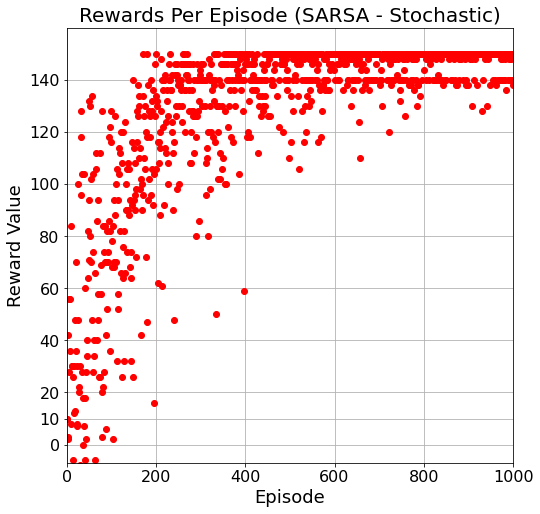

In [250]:
print(reward_sarsa_stoc)
plt.figure(figsize=(8,8))
plt.plot(reward_sarsa_stoc, 'ro')
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Reward Value', fontsize=18)
plt.title('Rewards Per Episode (SARSA - Stochastic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-60, -50, -20, 0, 10, 20, 40, 60, 80, 100, 120, 140], fontsize=16)
plt.ylim(ymin=-7, ymax=160)
plt.xlim(xmin=0, xmax=1000)
plt.grid()
plt.show()

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward ->  10


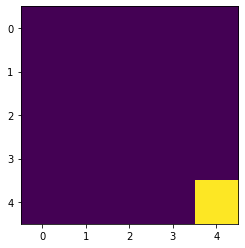

<IPython.core.display.Javascript object>

In [251]:
env = GridEnv(env_type = "stochastic")
agent = RandomAgent(env)

obs, info = env.reset()
terminated, truncated = False, False


output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

def get_max_val(arg):
  return max(arg)
  
for i in q_table_sarsa_stoc:
  max_val = get_max_val(i)
  i_to_list = i.tolist()
  max_index = i_to_list.index(max_val)
  observation, reward, terminated, truncated, info, agent_pos = env.step(max_index)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.imshow(grid)
    env.render()
  time.sleep(1)

  